In [1]:
import copy
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm

In [2]:
plt.rcParams['figure.figsize'] = (50, 10)

In [3]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sys.stdout.write(f'{device}')

cpu

In [4]:
# Model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(1152, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.avg_pool2d(F.relu(self.conv1(x)), 2)
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        return out

In [5]:
# Datasets and dataloaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform)

batch_size = 256
trainloader = DataLoader(train_dataset, batch_size=batch_size)
testloader = DataLoader(test_dataset, batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# Train and evaluate centralized
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train_losses_central = []
eval_losses_central = []
eval_acc_central = []

for ep in tqdm(range(20)):
    # Training
    ep_losses = []
    model.train()
    for xs, ys in trainloader:
        xs, ys = xs.to(device), ys.to(device)
        model.zero_grad()
        outputs = model(xs)
        loss = criterion(outputs, ys)
        loss.backward()
        optimizer.step()
        ep_losses.append(loss.item())
    ep_loss_avg = sum(ep_losses) / len(ep_losses)
    train_losses_central.append(ep_loss_avg)
    
    # Evaluation
    eval_loss = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for xs, ys in testloader:
            xs, ys = xs.to(device), ys.to(device)
            outputs = model(xs)
            loss = criterion(outputs, ys)
            eval_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            preds = preds.view(-1)
            correct += torch.sum(torch.eq(preds, ys)).item()
    eval_loss_avg = eval_loss / len(testloader)
    eval_losses_central.append(eval_loss_avg)
    eval_acc = correct / len(test_dataset)
    eval_acc_central.append(eval_acc)

  0%|          | 0/20 [00:00<?, ?it/s]

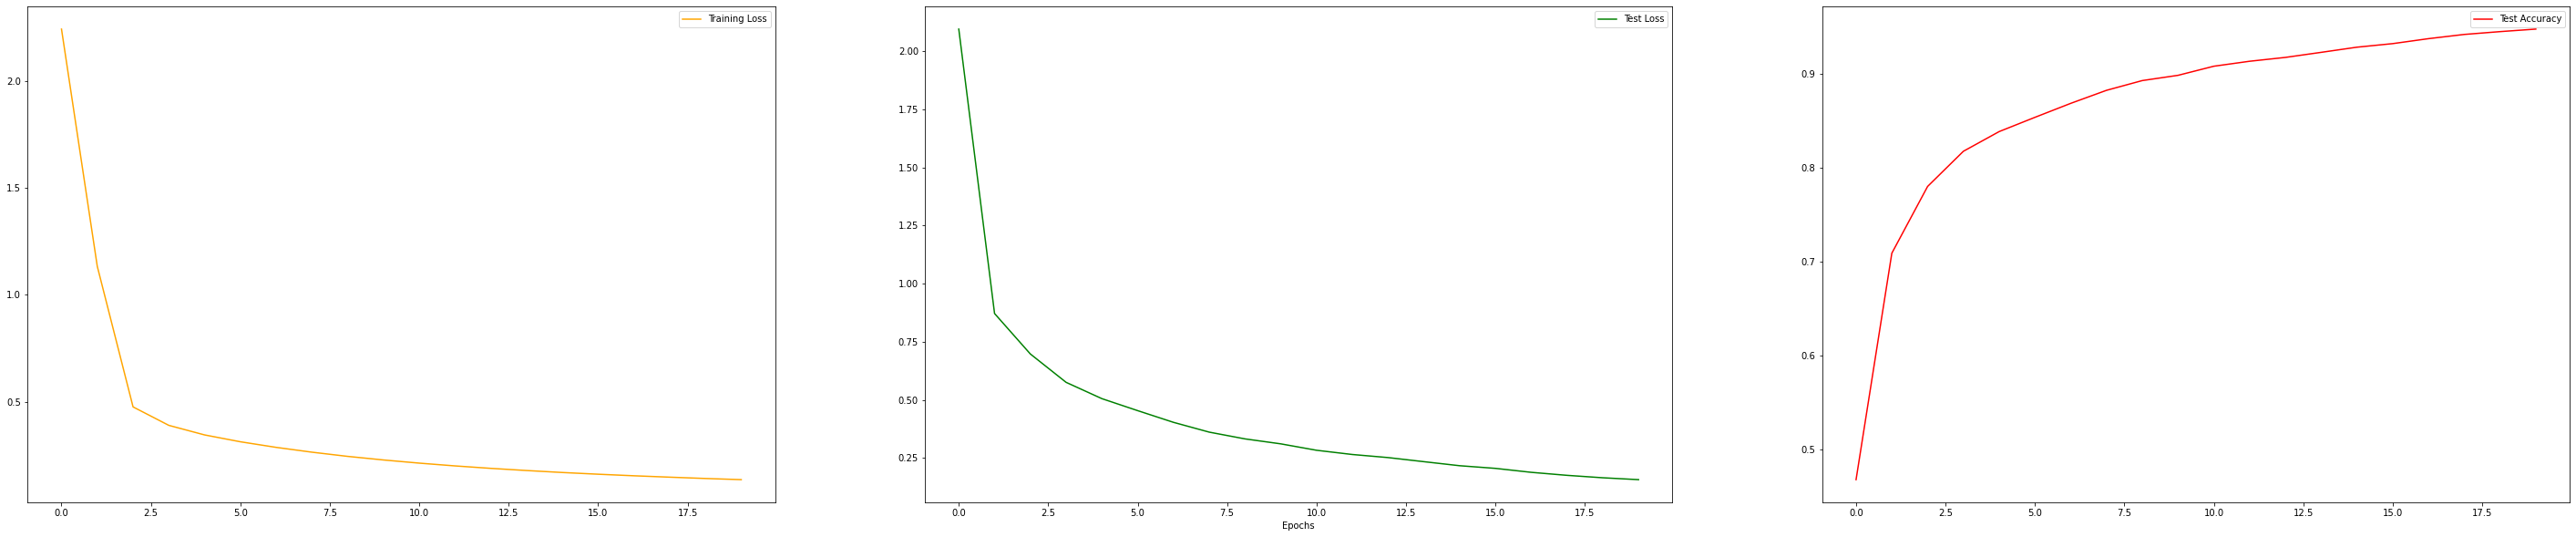

In [7]:
_, axs = plt.subplots(nrows=1, ncols=3, sharex=True)
axs[0].plot(train_losses_central, label='Training Loss', c='orange')
axs[0].legend()
axs[1].plot(eval_losses_central, label='Test Loss', c='green')
axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[2].plot(eval_acc_central, label='Test Accuracy', c='red')
axs[2].legend()
plt.show()

In [8]:
def train(model, loader, epochs):
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    losses = []

    model.train()
    for ep in range(epochs):
        ep_losses = []
        for xs, ys in loader:
            xs, ys = xs.to(device), ys.to(device)
            model.zero_grad()
            outputs = model(xs)
            loss = criterion(outputs, ys)
            loss.backward()
            optimizer.step()
            ep_losses.append(loss.item())
        ep_loss_avg = sum(ep_losses) / len(ep_losses)
        losses.append(ep_loss_avg)
    return model.state_dict(), losses

In [9]:
def average_weights(w):
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], float(len(w)))
    return w_avg

In [10]:
# 100 clients of IID local datasets
num_models = 100

x_idxs = np.arange(len(train_dataset))
ys = train_dataset.targets.numpy().copy()

trainloaders = []
for i in tqdm(range(num_models)):
    x_idxs, x_splits, ys, _ = train_test_split(x_idxs, ys, test_size=1 / num_models, shuffle=True, stratify=ys)
    sampler = SubsetRandomSampler(x_splits)
    trainloaders.append(DataLoader(train_dataset, batch_size=batch_size, sampler=sampler))

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
fed_model = Net().to(device)
fed_weights = fed_model.state_dict()

In [12]:
rounds = 100
epochs = 10

train_losses_fed = []
eval_losses_fed = []
eval_acc_fed = []

for r in tqdm(range(rounds)):
    local_weights = []
    local_losses = []
    if (r + 1) % 10 == 0:
        sys.stdout.write(f'\n | Global Training Round : {r + 1:>2d} / {rounds} |\n')
    
    fed_model.train()
    
    client_idxs = sorted(np.random.randint(0, num_models, 10))
    for i, tr in enumerate(trainloaders):
        if i in client_idxs:
            w, ls = train(copy.deepcopy(fed_model), tr, epochs)
            local_weights.append(copy.deepcopy(w))
            train_losses_fed.append(ls)
            if (r + 1) % 10 == 0:
                sys.stdout.write('  |-- [Client {:>2}] Average Train Loss: {:.4f} ... {} local epochs\n'.format(i + 1, sum(ls) / len(ls), epochs))
            
    fed_weights = average_weights(local_weights)
    fed_model.load_state_dict(fed_weights)

    # Evaluation
    eval_loss = 0
    correct = 0
    fed_model.eval()
    with torch.no_grad():
        for xs, ys in testloader:
            xs, ys = xs.to(device), ys.to(device)
            outputs = fed_model(xs)
            loss = criterion(outputs, ys)
            eval_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            preds = preds.view(-1)
            correct += torch.sum(torch.eq(preds, ys)).item()
    eval_loss_avg = eval_loss / len(testloader)
    eval_losses_fed.append(eval_loss_avg)
    eval_acc = correct / len(test_dataset)
    eval_acc_fed.append(eval_acc)
    if (r + 1) % 10 == 0:
        sys.stdout.write(f'    |---- Test Loss: {eval_loss_avg:.4f}\n')
        sys.stdout.write(f'    |---- Test Accuracy: {100 * eval_acc:.4f}%\n')

  0%|          | 0/100 [00:00<?, ?it/s]


 | Global Training Round : 10 / 100 |
  |-- [Client  8] Average Train Loss: 2.1751 ... 10 local epochs
  |-- [Client 16] Average Train Loss: 2.1786 ... 10 local epochs
  |-- [Client 30] Average Train Loss: 2.1824 ... 10 local epochs
  |-- [Client 40] Average Train Loss: 2.1829 ... 10 local epochs
  |-- [Client 41] Average Train Loss: 2.1821 ... 10 local epochs
  |-- [Client 47] Average Train Loss: 2.1796 ... 10 local epochs
  |-- [Client 61] Average Train Loss: 2.1808 ... 10 local epochs
  |-- [Client 65] Average Train Loss: 2.1800 ... 10 local epochs
  |-- [Client 66] Average Train Loss: 2.1843 ... 10 local epochs
  |-- [Client 82] Average Train Loss: 2.1769 ... 10 local epochs
    |---- Test Loss: 2.1567
    |---- Test Accuracy: 29.8000%

 | Global Training Round : 20 / 100 |
  |-- [Client 29] Average Train Loss: 0.5855 ... 10 local epochs
  |-- [Client 46] Average Train Loss: 0.6127 ... 10 local epochs
  |-- [Client 53] Average Train Loss: 0.7073 ... 10 local epochs
  |-- [Client 6

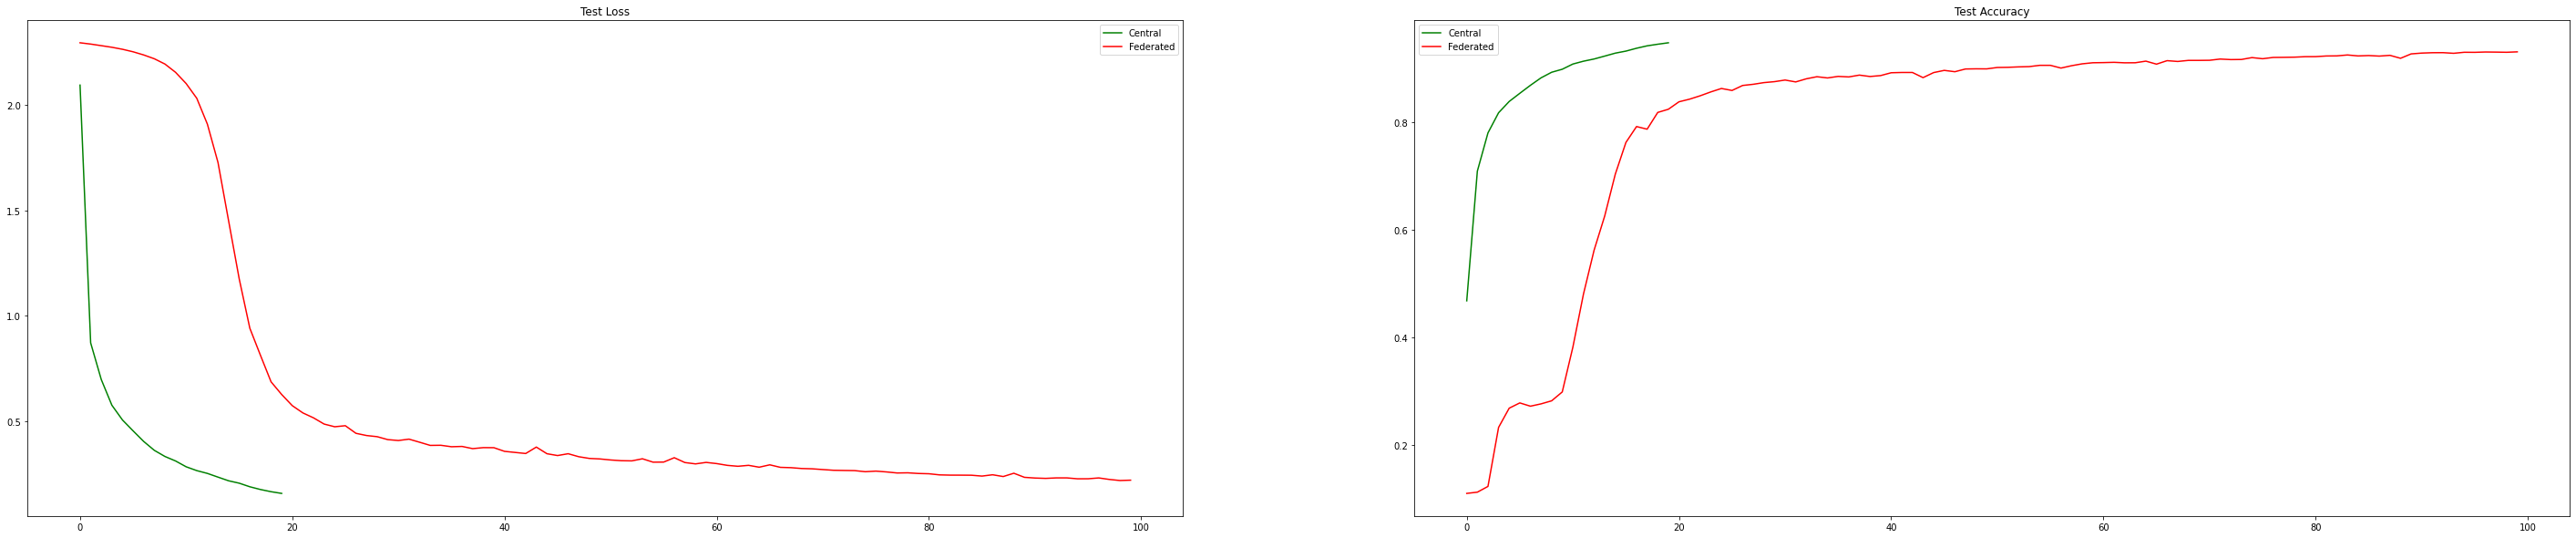

In [13]:
_, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
axs[0].plot(eval_losses_central, label='Central', c='green')
axs[0].plot(eval_losses_fed, label='Federated', c='red')
axs[0].legend()
axs[0].set_title('Test Loss')
axs[1].plot(eval_acc_central, label='Central', c='green')
axs[1].plot(eval_acc_fed, label='Federated', c='red')
axs[1].legend()
axs[1].set_title('Test Accuracy')
plt.show()